In [1]:
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from collections import deque
from skimage.feature import hog
from skimage import data, exposure
import time
import cv2 as cv2
import pickle
import numpy as np

# load the model from disk
classifier1 = pickle.load(open('classifier3_Linearsvm_16_8_2.xml', 'rb'))

C:\Users\pc\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LinearSVC from version 0.24.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
""" HOG functions """
# Return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        hog_features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualize=vis, feature_vector=feature_vec)
        return hog_features, hog_image
    # Otherwise call with one output
    else:      
        hog_features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       visualize=vis, feature_vector=feature_vec)
        return hog_features

In [3]:
# Return extracted features 
def ExtractFeatures(images, orient, pix_per_cell, cell_per_block):
    featureList = []
    for Img in images:
        local_features = get_hog_features(Img, orient, pix_per_cell, cell_per_block, True, True)
        featureList.append(local_features)
    return featureList

In [4]:
# convert RGB image to gray
def convert_Image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(32,32))
    return img

 # slide a window across the image
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            # generate a windows
            

In [5]:
def Detect_cars(image,dim,cars):
    # covert image to gray
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    winW, winH = dim[0], dim[1]
    step = winW // 3
    for (x, y, window) in sliding_window(img, stepSize=step, windowSize=(winW, winH)):
        win = cv2.resize(window,(32,32),interpolation = cv2.INTER_AREA)
        hog_features = get_hog_features(win, 16, 8, 2, False, True)
        predictedOutput=classifier1.predict([hog_features])
        if(predictedOutput==1):
            #cv2.rectangle(image, (x, y), (x + winW, y + winH), (255, 0, 0), 3)
            cars.append((x,y,winW))
        # if the window does not meet our desired window size, ignore it
        #if window.shape[0] != 30 or window.shape[1] != 30:
        
    return image,cars

In [6]:
'''
def pyramid(image):
    img = image.copy()
    for i in range(3):
        img = Detect_cars(img)
        scale_percent = 50 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        
    for i in range(3):
        scale_percent = 150 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)
        # resize image
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    return img
'''

def pyramid(image):
    cars=[]
    shape = image.shape
    size = [(128,128),(266,266),(382,382)]
    for (W,H) in size:
        #winH = shape[0] // H
        #winW = shape[1] // W
        image,cars = Detect_cars(image,(W,H),cars)
    
    return image,cars
   

In [7]:
# Functions to remove duplicate detections and false positives

def add_heat(heatmap, bbox_list):
    """
        Iterate the windows with detected cars and enhance the once with highest detections.
    """
    for (x,y,win) in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[y:y+win, x:x+win] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    """
        Only keep the detections that have a minimum number of pixels.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

In [8]:
def detection(im):
    image = np.copy(im)
    img,cars = pyramid(image)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, cars)
    recent_heatmaps = deque(maxlen=10)
    recent_heatmaps.append(heat)

    # Take the mean of last n frames as discard the windows that are below the threshold
    heatmap = apply_threshold(np.mean(recent_heatmaps, axis=0),1.5)
    #labled, num = label(heatmap_img)
    labels = label(heatmap)
    finaleImg = draw_labeled_bboxes(im, labels)
    return finaleImg

(720, 1280, 3)


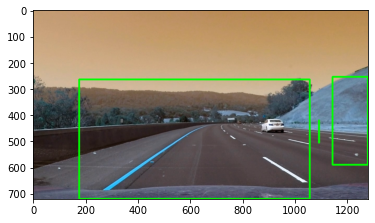

--- 0.6533846855163574 seconds ---


In [9]:
start_time = time.time()
image = cv2.imread("test3.jpg")
img = detection(image)

print(img.shape)
plt.imshow(img)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [10]:
"""
image = cv2.imread("test3.jpg")
#heatmap_img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, cars)
recent_heatmaps = deque(maxlen=10)
recent_heatmaps.append(heat)
    
# Take the mean of last n frames as discard the windows that are below the threshold
heatmap = apply_threshold(np.mean(recent_heatmaps, axis=0),1.5)
#labled, num = label(heatmap_img)
labels = label(heatmap)

print(labels[1])
plt.imshow(heatmap)
plt.show()
image = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(image)
plt.show()
"""

'\nimage = cv2.imread("test3.jpg")\n#heatmap_img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)\nheat = np.zeros_like(img[:,:,0]).astype(np.float)\nheat = add_heat(heat, cars)\nrecent_heatmaps = deque(maxlen=10)\nrecent_heatmaps.append(heat)\n    \n# Take the mean of last n frames as discard the windows that are below the threshold\nheatmap = apply_threshold(np.mean(recent_heatmaps, axis=0),1.5)\n#labled, num = label(heatmap_img)\nlabels = label(heatmap)\n\nprint(labels[1])\nplt.imshow(heatmap)\nplt.show()\nimage = draw_labeled_bboxes(np.copy(image), labels)\nplt.imshow(image)\nplt.show()\n'

In [11]:
#video_src = 'project_video.mp4'
video_src = 'vid.3gp'

cap = cv2.VideoCapture(video_src)
    
while True:
    ret, frame = cap.read()
    if (type(frame) == type(None)):
        break
        
    image = np.copy(frame)
    img, cars = pyramid(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, cars)
    recent_heatmaps = deque(maxlen=10)
    recent_heatmaps.append(heat)
    # Take the mean of last n frames as discard the windows that are below the threshold
    heatmap = apply_threshold(np.mean(recent_heatmaps, axis=0),1.5)
    #labled, num = label(heatmap_img)
    labels = label(heatmap)
    finalPic = draw_labeled_bboxes(frame, labels)
    cv2.imshow('video', finalPic)
    
    if cv2.waitKey(1) == 27:
        break
        

cv2.destroyAllWindows()

print("done!")

done!
